In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from IPython.display import Image

import matplotlib.pyplot as plt

import seaborn as sns
import catboost

In [2]:
def deleteId(ds):
    return ds.drop(columns='Id')

def deleteNaN(train_ds, test_ds, critval):
    fullsize = train_ds.shape[0]
    new_train = train_ds.copy()
    new_test = test_ds.copy()
    for feature in new_train.columns:
        nulls = new_train[feature].isnull().sum()
        percent = nulls / fullsize
        if (percent > critval):
            new_train = new_train.drop(columns=feature)
            new_test = new_test.drop(columns=feature)
    return new_train, new_test

def convertToNumeric(train_ds, test_ds):
    new_train = train_ds.copy()
    new_test = test_ds.copy()
    LE = LabelEncoder()
    for feature in new_train.columns[:-1]:
        if (new_train[feature].dtype == 'object'):
            new_train[feature] = LE.fit_transform(new_train[feature])
            new_test[feature] = LE.fit_transform(new_test[feature])
    return new_train, new_test

def check_error(preds, gt):
    print('RMSE Error:', mean_squared_error(np.log(preds), np.log(gt), squared=False))

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train = train.drop_duplicates()

train.SalePrice.describe()



count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/tmp/ipykernel_104736/686805026.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr().round(2)


<AxesSubplot: >

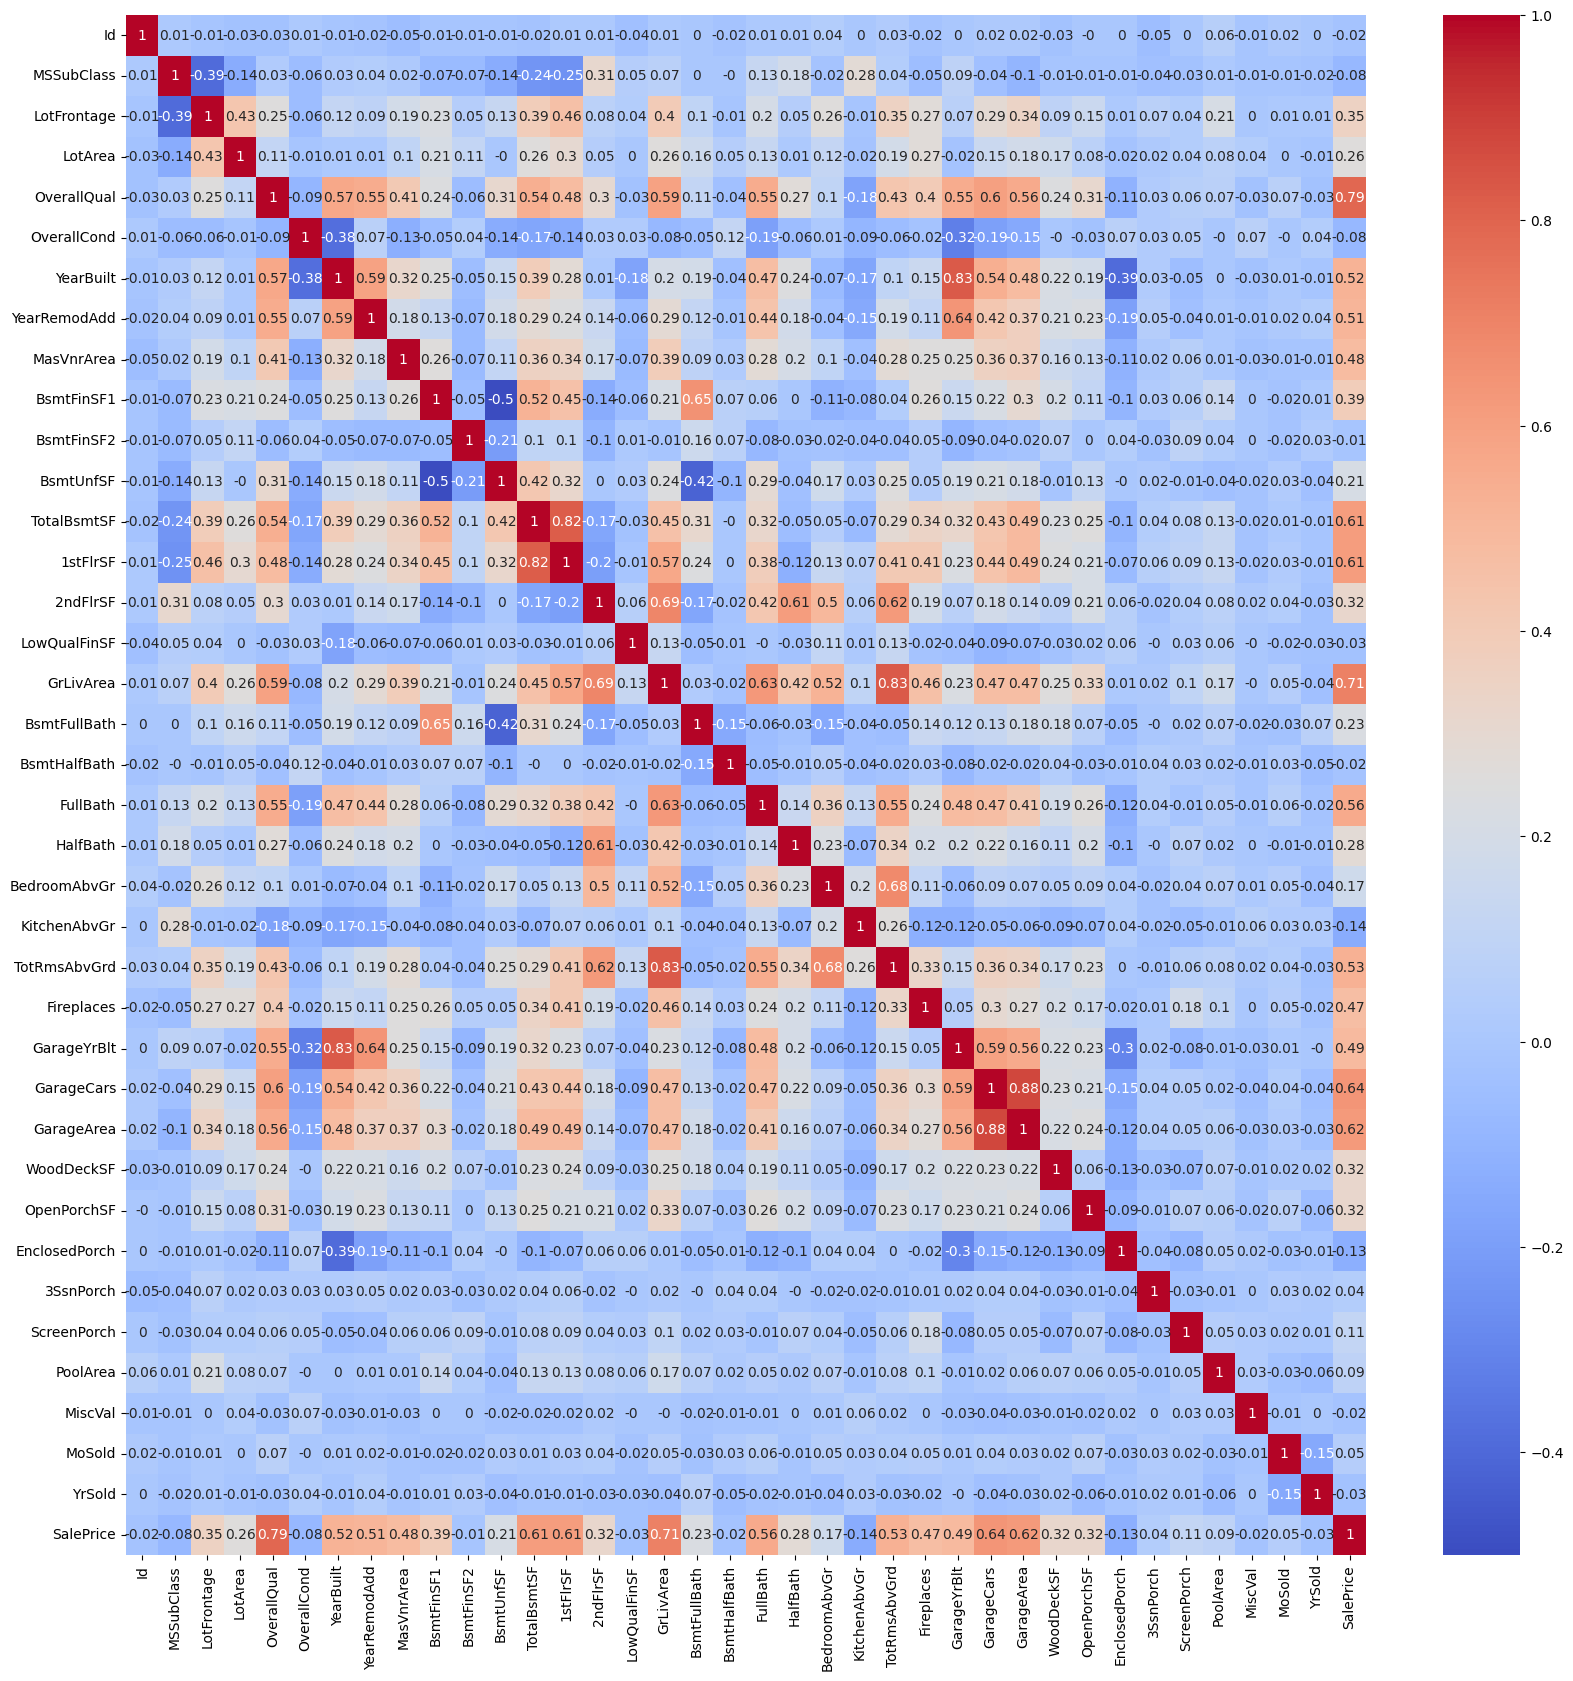

In [4]:
plt.figure(figsize=(20, 20))
corr_matrix = train.corr().round(2)
sns.heatmap(data=corr_matrix,cmap='coolwarm',annot=True)

In [5]:
train = deleteId(train)  
train, test = deleteNaN(train, test ,critval=0.7)
train, test = convertToNumeric(train, test)

y_train = train['SalePrice'].values
x_train = train.drop(columns='SalePrice').values
x_super_test = test.values


X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=98987)

imp = SimpleImputer(strategy='mean')
X_train = imp.fit_transform(X_train)
X_test = imp.fit_transform(X_test)

### PCA + Scaler


In [6]:
pca = PCA(n_components = 20)
X_train = pca.fit_transform(X_train, y_train)
X_test = pca.transform(X_test)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

### Random Forest

In [7]:
parameters = {
    'criterion':(['squared_error']), 
    'max_depth': (1000, 1500, 2000, None),
    
    'n_estimators':(5, 10, 20, 50),
    'min_samples_split':(2, 5, 9)}

model = RandomForestRegressor()
gs_model = GridSearchCV(model, parameters)
gs_model.fit(X_train[:300], y_train[:300])
print(f"Best parameters: {gs_model.best_params_}")

Best parameters: {'criterion': 'squared_error', 'max_depth': 2000, 'min_samples_split': 5, 'n_estimators': 10}


In [8]:
model = RandomForestRegressor(**gs_model.best_params_)
model.fit(X_train, y_train)
check_error(model.predict(X_test), y_test)


RMSE Error: 0.21760900305156752


### AdaBoost

In [9]:
parameters = {
    "learning_rate": (0.05, 0.1, 0.15),
    'loss':(['square', 'linear', 'exponential']), 
    
    
    'n_estimators':(5, 10, 20, 50)
    }

model = AdaBoostRegressor()
gs_model = GridSearchCV(model, parameters)

gs_model.fit(X_train[:500], y_train[:500])
print(f"Best parameters: {gs_model.best_params_}")

Best parameters: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 10}


In [10]:
model = AdaBoostRegressor(**gs_model.best_params_)
model.fit(X_train, y_train)
check_error(model.predict(X_test), y_test)

RMSE Error: 0.28087186576671785


### XGBoost

### Loss functions
Regression loss functions
$L(y,f) = (y -f)^2$

$L(y, f) = |y -f|$


Classification loss functions
$L(y, f) = \log{1 + \exp(-2yf)}$ - logistic

$L(y, f) = \exp{-yf}$ -ada boost


### GBM Algorithm
1. Initialize GBM with constant value $\hat{f(x)} = \hat{f_0}$,

$\hat{f_0} = argmin \sum_{i=1}^{n}{L(y_i,\gamma)}$

2. For each iteration t = 1..M

3. Calculate $r_{it} = -\frac{\partial{L(y_i, f(x_i))}}{\partial{f(x_i)}}$

4. Build new base algorithm $h_t(x)$  as regression on pseudo-residuals ${(x_i, r_{it})}$ 

5. Find optimal coefficient $\rho_t$  at $h_t(x)$  regarding initial loss function

$\rho_t = argmin \sum_{i=1}^{n}{L(y_i, \hat{f(x_i)} + \rho \cdot h(x_i, \theta))}$

6. $\hat{f}_t(x) = \rho_t \cdot h_t(x)$


7. Update approximation $\hat{f}(x) <- \sum_{i = 0}^{t}{f_i(x)}$

8. $\hat{f}(x) = \sum_{i = 0}^{M}{f_i(x)}$


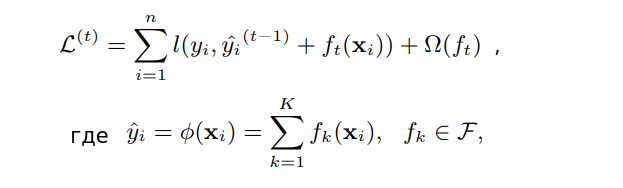

In [11]:
Image("images/xgb_1.png")

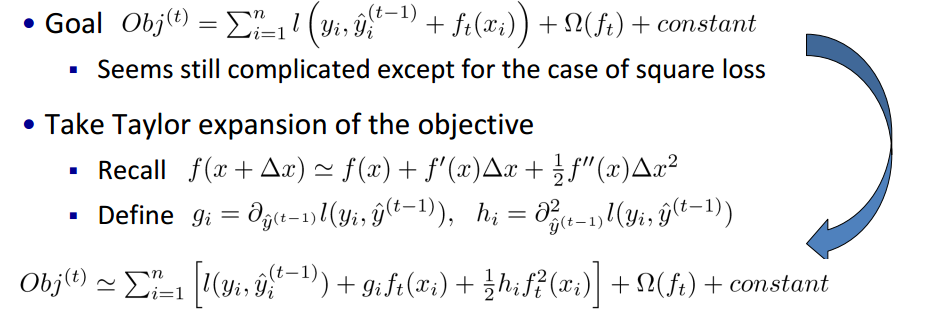

In [12]:
Image("images/xgb_taylor.png")

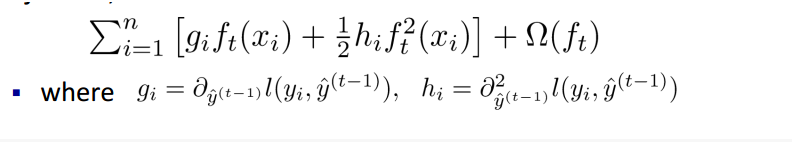

In [13]:
Image("images/xgboost_empirical.png")

$\Omega (f_t) = \gamma T + \frac{1}{2}\lambda\sum_{j=1}^{T}w_j^2$

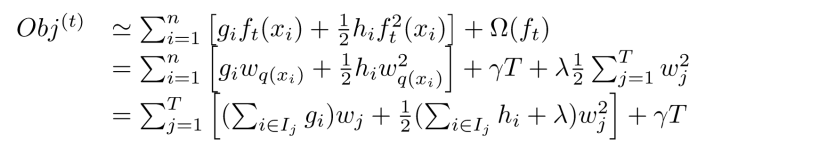

In [14]:
Image("images/xgb_leafs_regroup.png")

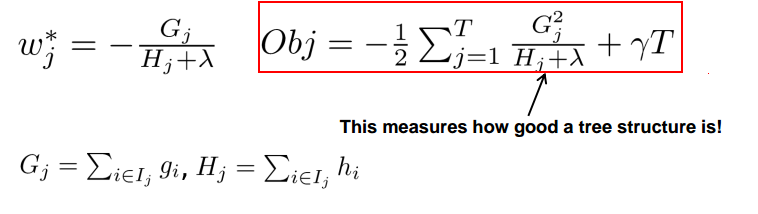

In [15]:
Image("images/xgb_tree_quality.png")

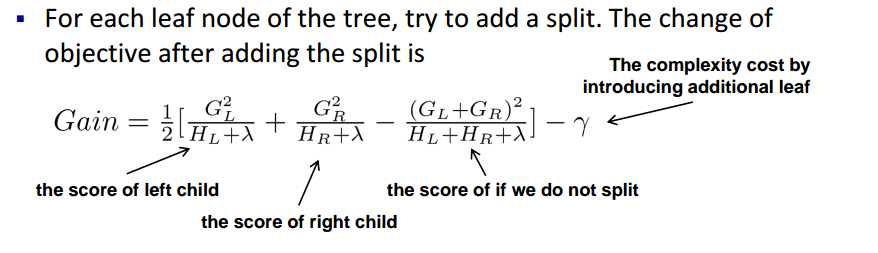

In [16]:
Image("images/xgb_tree_split_criteria.png")

In [17]:
parameters = {
    "learning_rate": (0.05, 0.1, 0.15),
    "max_depth": [4, 5, 6],
    "min_child_weight": [7, 9, 12],
    "n_estimators":(30,50, 70)}

model = XGBRegressor()
gs_model = GridSearchCV(model, parameters)
gs_model.fit(X_train[:300], y_train[:300])


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'learning_rate': (0.05, 0.1, 0.15),
                         'max_depth': [4, 5, 6], 'min_child_weight': [7, 9, 12],
                         'n_estimators': (30, 50, 70)})

In [18]:
model = XGBRegressor(**gs_model.best_params_)
model.fit(X_train, y_train)
check_error(model.predict(X_test), y_test)

RMSE Error: 0.2029348814603594


### LightGBM



В отличие от поуровневого (горизонтального) роста в XGBoost, LightGBM выполняет листовой (вертикальный) рост, что приводит к большему снижению потерь и, в свою очередь, к более высокой точности при более высокой скорости. 

In [19]:
model = LGBMRegressor()

parameters = {
    'num_leaves': [i for i in range(3,15,2)],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [50, 100],}

gs_model = GridSearchCV(model, parameters)
gs_model.fit(X_train[:300], y_train[:300])
print(f"Best parameters: {gs_model.best_params_}")

Best parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 50, 'num_leaves': 11}


In [20]:
model = LGBMRegressor(**gs_model.best_params_)
model.fit(X_train, y_train)
check_error(model.predict(X_test), y_test)

RMSE Error: 0.24040962990936537


# Cat Boost
1) В качестве базового алгоритма используются небрежные решающие деревья (ODT - Obvious Decision Tree)
2) В качестве метода ансаблированния используется модифицированный градиентный бустинг. Суть его следующая:
   * Перед обучением создаётся s перестановок обучающей выборки $X_1, X_2, ..., X_s$. 
   * Кадая из этих перестановок $X_\sigma$ делится на части, длина которых возрастает в геометрической прогрессии ($2^i$). 
   * Каждый новый алгоритм ансамбля $b_t$ строится на перстановке $X_\sigma$, где $\sigma$ выбирается случайным образом от 0 до s
   * $$b_t := \arg\min_b\sum_{i=1}^{l}{(b(x_i) + g_{ti})^2}$$
   * Градиент $g_{ti}$ вычисляется по выборке $X^{\sigma j}$, где j - это подвыборка перстановки в которой не учасвствовал объект $x_i$
   * $$g_{t i} = \mathcal{L}'(a^{r j}_{t-1}(x_i), y_i) $$
   * $$j = \log_2(i - 1)$$
3) Следующая фича - работа с категориальными признаками. Категориальные признаки преобразуются в вещественные с помощью метода статистики по целевому признаку (TS).


In [21]:
model = CatBoostRegressor()

parameters = {
        'learning_rate': [0.07, 0.9],
        'depth': [1, 2, 3],
        'l2_leaf_reg': [0.7, 1, 1.3],}

gs_model = GridSearchCV(model, parameters)
gs_model.fit(X_train[:300], y_train[:300])
print(f"Best parameters: {gs_model.best_params_}")

0:	learn: 79372.1300352	total: 46ms	remaining: 46s
1:	learn: 77104.3480710	total: 46.4ms	remaining: 23.1s
2:	learn: 74904.8074202	total: 46.6ms	remaining: 15.5s
3:	learn: 73104.7175671	total: 46.6ms	remaining: 11.6s
4:	learn: 71758.2011183	total: 46.7ms	remaining: 9.3s
5:	learn: 70311.5680604	total: 46.8ms	remaining: 7.76s
6:	learn: 68750.3070846	total: 46.9ms	remaining: 6.65s
7:	learn: 67263.9668961	total: 47ms	remaining: 5.83s
8:	learn: 66237.1587617	total: 47.1ms	remaining: 5.18s
9:	learn: 64864.6776361	total: 47.2ms	remaining: 4.67s
10:	learn: 63774.6770942	total: 47.2ms	remaining: 4.25s
11:	learn: 63099.7664984	total: 47.3ms	remaining: 3.9s
12:	learn: 62210.4605406	total: 47.4ms	remaining: 3.6s
13:	learn: 61287.6838629	total: 47.5ms	remaining: 3.34s
14:	learn: 60338.5161398	total: 47.6ms	remaining: 3.12s
15:	learn: 59717.9835535	total: 47.6ms	remaining: 2.93s
16:	learn: 59028.8145183	total: 47.7ms	remaining: 2.76s
17:	learn: 58093.3490321	total: 47.8ms	remaining: 2.61s
18:	learn: 

In [22]:
def getCategorialFeatures(train_ds):
    cat_features = []
    iter = 0
    for feature in train_ds.columns[:-1]:
        if (train_ds[feature].dtype == 'object'):
            cat_features.append(iter)
        iter +=1 
    return cat_features

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train = train.drop_duplicates()

train = deleteId(train)  
train, test = deleteNaN(train, test ,critval=0.7)
cat_features = getCategorialFeatures(train)

y_train = train['SalePrice'].values
x_train = train.drop(columns='SalePrice').values
x_super_test = test.values

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=98987)

imp = SimpleImputer(strategy='most_frequent')
X_train = imp.fit_transform(X_train)
X_test = imp.fit_transform(X_test)

In [23]:
model = CatBoostRegressor(loss_function='RMSE',cat_features=cat_features, depth=3, learning_rate=0.07, l2_leaf_reg=0.7)
model.fit(X_train, y_train, plot=True)
check_error(model.predict(X_test), y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 75594.1765720	total: 2.96ms	remaining: 2.96s
1:	learn: 72577.7981164	total: 9.16ms	remaining: 4.57s
2:	learn: 69815.7784446	total: 11.6ms	remaining: 3.86s
3:	learn: 67347.5156012	total: 14.3ms	remaining: 3.55s
4:	learn: 64745.3381978	total: 16.7ms	remaining: 3.33s
5:	learn: 62548.9468199	total: 18.9ms	remaining: 3.13s
6:	learn: 60462.6132989	total: 22.7ms	remaining: 3.22s
7:	learn: 58363.9795038	total: 26.1ms	remaining: 3.24s
8:	learn: 56161.5775622	total: 28.6ms	remaining: 3.15s
9:	learn: 54567.9145194	total: 30.6ms	remaining: 3.03s
10:	learn: 52762.9305134	total: 32.4ms	remaining: 2.91s
11:	learn: 51131.3028937	total: 34.5ms	remaining: 2.84s
12:	learn: 49812.8716515	total: 40.1ms	remaining: 3.04s
13:	learn: 48317.2385416	total: 43.1ms	remaining: 3.03s
14:	learn: 46857.8476508	total: 45.4ms	remaining: 2.98s
15:	learn: 45678.8840846	total: 55.7ms	remaining: 3.43s
16:	learn: 44618.1325948	total: 58.2ms	remaining: 3.36s
17:	learn: 43589.0392256	total: 60.4ms	remaining: 3.29s
18

In [27]:
test_ds = pd.read_csv('data/test.csv')

cat_features = test_ds.select_dtypes(['object']).columns.tolist()

y_pred = model.predict(test_ds)

y_pred = np.expm1(y_pred)

In [28]:
my_submission = pd.read_csv('data/sample_submission.csv')
my_submission['SalePrice'] = y_pred

my_submission.to_csv('sample_submission.csv',index=False)